##Workplace Fairness
#Locating Pay Inequality
How do we find pay inequality at our workplace? This notebook discusses a simple approach to detect where the problem is.

The following cell ingests the original data, which is randomly generated, deletes rows with null values, and print a few rows of the ingested data.

The random seed is set for the functions in the later section where the synthetic data is generated.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

df = pd.read_csv('workplace_fairness.csv')
df.dropna() ## delete rows with null values
print(df.head())

np.random.seed(333)

  employee_id  department       salary  gender        city  \
0    ABCD1234  Accounting  34563.90872  female  Pittsburgh   
1    ABCD1234  Accounting  44083.51669  female  Pittsburgh   
2    ABCD1234  Accounting  82661.36445  female  Pittsburgh   
3    ABCD1234  Accounting  34374.23567  female  Pittsburgh   
4    ABCD1234  Accounting  65352.55980  female  Pittsburgh   

   years_of_experience  last_salary_increase  distance_from_office  
0            16.198675           3153.429121             19.001779  
1            13.627483           3658.981392              5.580490  
2            14.070442           3498.141749             11.016431  
3             8.689876           2951.603145             34.917228  
4            12.268793           3040.972868             19.685092  


To replicate the dimensions or attributes in the original data set, this step is needed. The following cell finds all possible unique combinations of the dimensions and store them in a data frame.

In [ ]:
## unique values of dimensions
groupby_dimension = df[['department', 'gender', 'city']].groupby(['department', \
                        'gender', 'city']).count().reset_index()

The following cell is the main section of this notebook. It contains the Gaussian Copula discussed in detail in the following book.
https://mltechniques.com/product/ebook-synthetic-data/

The number of metrics to be synthesized is declared in the beginning of the cell. The array zero with length equal to the number of metrics is declared. The zero array is will be used to generated the multivariate normal distributions.

Using the data frame created in the previous cell, the code loops and does the following.
* Obtain all the values for each group. Each group is a combination of unique department, gender, and city. Store these values in an array.
* Store each metric in an array.
* Stack the arrays and store them in an array, which basically transpose the first array.
* Calculate the correlations of the stack array, store the values in an array.
* Count the rows of the cohort, this is the number of rows of the to-be-created synthetic data.
* Generate multivariate distributions using the zero and correlation arrays.
* Store the values generated above in separate arrays. One array for each metric.
* Create an inner loop which generates normal cumulative distributed values for each metric. Find the quantile of the values from the previous step in the values generated by the cumulative distributed values.
* Store the values above in a row. Insert the row into the output data frame.

In [ ]:
## set number of metrics
metric_count = 4 ## salary years_of_experience last_salary_increase distance_from_office
zero = [0] * metric_count

## construct output data frame
synthetic_data = pd.DataFrame()

## loop through unique dimension values
for index, row in groupby_dimension.iterrows():
    department = row['department']
    gender = row['gender']
    city = row['city']

    ## collect numerical fields in one matrix
    group_matrix = df.loc[(df['department']==department) & (df['gender']==gender)\
                          & (df['city']==city)][['salary', 'years_of_experience', \
                                                 'last_salary_increase', \
                                                 'distance_from_office']]

    ## convert data frame to list
    salary = group_matrix['salary'].values.tolist()
    years_of_experience = group_matrix['years_of_experience'].values.tolist()
    last_salary_increase = group_matrix['last_salary_increase'].values.tolist()
    distance_from_office = group_matrix['distance_from_office'].values.tolist()

    ## correlation of numerical values
    z = np.stack((salary, years_of_experience, last_salary_increase, \
                  distance_from_office), axis=0)
    corr = np.corrcoef(z)

    ## row count of matrix
    row_count = len(group_matrix.index)

    ## generate multivariate nomal distribution
    gfg = np.random.multivariate_normal(zero, corr, row_count)

    ## store elements of matrix in separate lists
    g_salary = gfg[:, 0]
    g_years_of_experience = gfg[:, 1]
    g_last_salary_increase = gfg[:, 2]
    g_distance_from_office = gfg[:, 3]

    ## means of numerical fields
    means = [np.mean(salary), np.mean(years_of_experience), \
             np.mean(last_salary_increase), np.mean(distance_from_office)]

    ## for each row generate synthetic values
    for i in range(row_count):
      u_salary = stats.norm.cdf(g_salary[i])
      s_salary = np.quantile(salary, u_salary)
      u_years_of_experience = stats.norm.cdf(g_years_of_experience[i])
      s_years_of_experience = np.quantile(years_of_experience, u_years_of_experience)
      u_last_salary_increase = stats.norm.cdf(g_last_salary_increase[i])
      s_last_salary_increase = np.quantile(last_salary_increase, u_last_salary_increase)
      u_distance_from_office = stats.norm.cdf(g_distance_from_office[i])
      s_distance_from_office = np.quantile(distance_from_office, u_distance_from_office)

      ## store synthetic values in data frame
      new_row = [{'department':department, \
                           'gender':gender, \
                           'city':city, \
                           'salary':s_salary, \
                           'years_of_experience':s_years_of_experience, \
                           'last_salary_increase':s_last_salary_increase, \
                           'distance_from_office':s_distance_from_office}]
      new_row_df = pd.DataFrame(new_row)

      ## append generated synthetic values to output data frame
      synthetic_data = pd.concat([synthetic_data, new_row_df], ignore_index=True)

print('synthetic_data: ' + str(synthetic_data.head()))


synthetic_data:    department  gender        city        salary  years_of_experience  \
0  Accounting  female  Pittsburgh  67896.862144             8.703431   
1  Accounting  female  Pittsburgh  85000.075692            10.992142   
2  Accounting  female  Pittsburgh  79733.186089            16.675769   
3  Accounting  female  Pittsburgh  79507.096881             7.829728   
4  Accounting  female  Pittsburgh  43318.828870            15.824422   

   last_salary_increase  distance_from_office  
0           3497.389968             15.545756  
1           3119.637015             12.758178  
2           3038.921432             15.656088  
3           2957.209868             30.831834  
4           2841.208134             25.896501  


## Original Data
We want to know how alike the original and synthetic data sets are. The following cell grabs the necessary fields from the original data set and produces the basic statistics of the data set.

In [ ]:
original_data = df[['department', 'gender', 'city', 'salary', 'years_of_experience', \
                    'last_salary_increase', 'distance_from_office']]
print('original data')
original_data[['salary', 'years_of_experience', 'last_salary_increase', 'distance_from_office']].describe()

original data


,salary,years_of_experience,last_salary_increase,distance_from_office
count,19504.000000,19504.000000,19504.000000,19504.000000
mean,80247.632977,11.992173,2999.192465,19.970683
std,29846.136572,2.999371,301.076049,7.965259
min,51.238276,0.424706,1625.111815,0.013129
25%,59856.591102,9.982993,2799.394570,14.545314
50%,80287.909575,11.982437,2998.259906,20.019071
75%,100752.144575,13.990420,3199.661071,25.322239
max,205391.693800,25.122743,4139.265718,53.058916


## Synthetic Data
The following cell prints the basic statistics of the synthetic data.

In [ ]:
print('synthetic data')
synthetic_data[['salary', 'years_of_experience', 'last_salary_increase', \
                'distance_from_office']].describe()

synthetic data


,salary,years_of_experience,last_salary_increase,distance_from_office
count,19504.000000,19504.000000,19504.000000,19504.000000
mean,80326.900713,11.954417,2998.027973,19.902470
std,29505.107715,2.945408,297.464116,7.845604
min,715.372558,0.492993,1645.730021,0.031662
25%,60314.314160,10.009452,2800.600858,14.500900
50%,80325.918322,11.933983,2998.936005,19.993077
75%,100659.001845,13.905197,3196.926491,25.299817
max,182660.425299,23.260663,3958.522202,46.676622


## Distribution Plots of the Original and Synthetic Data
The charts compares the female and male salary distributions. These charts are used to quickly examine how different the original and synthetic data are.

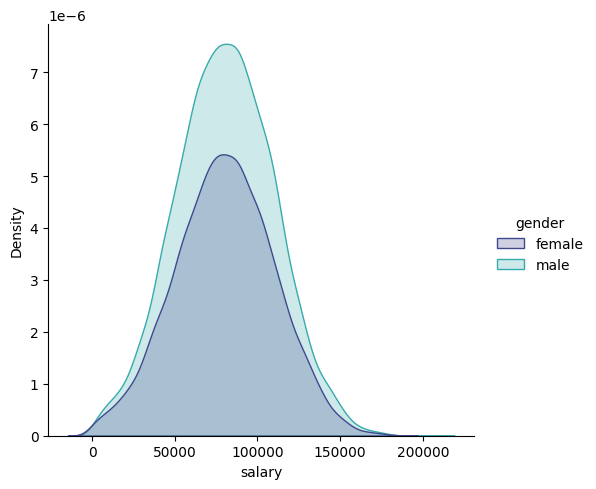

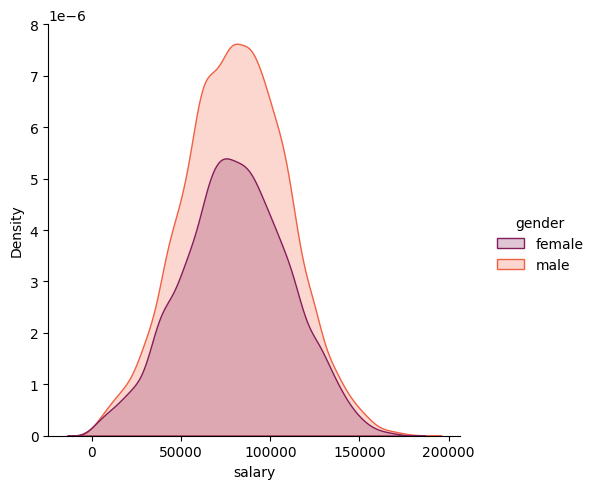

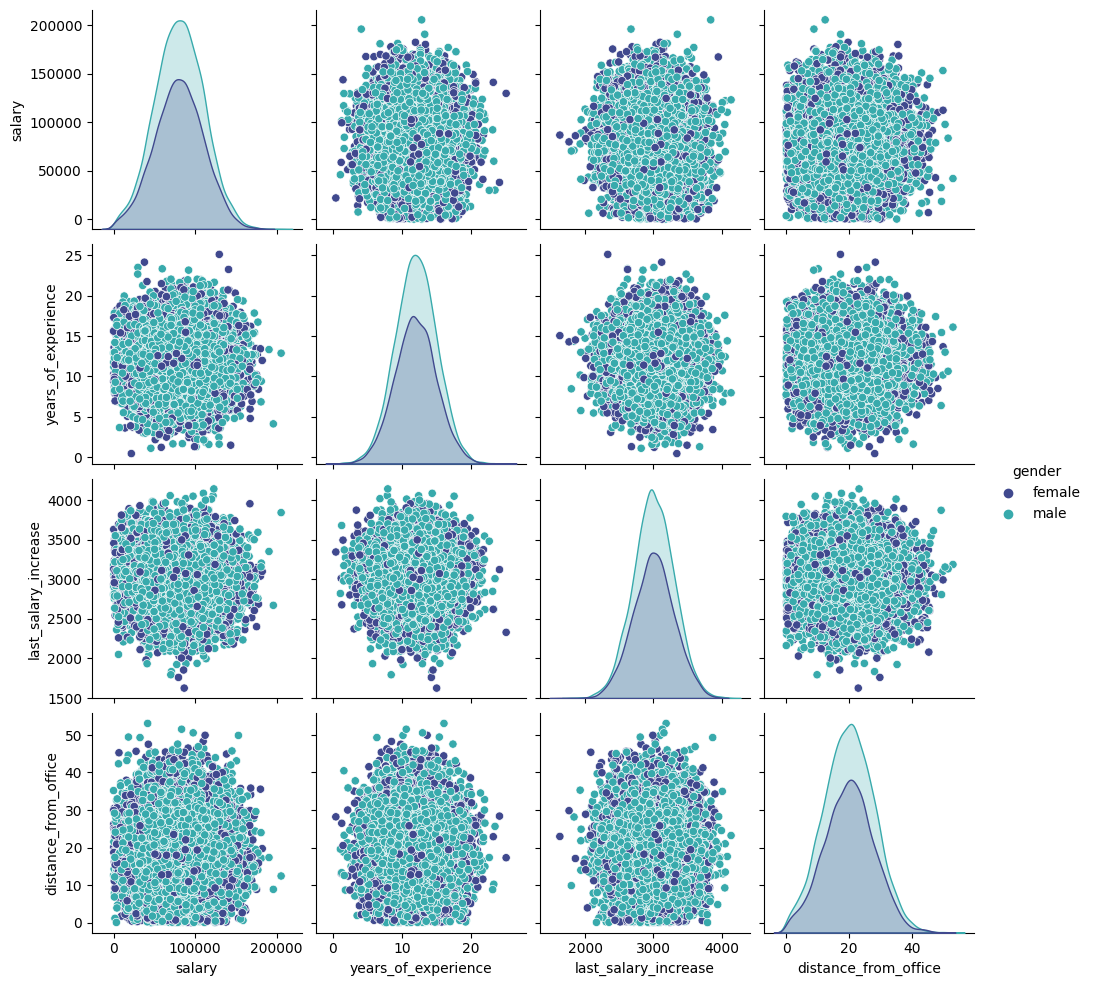

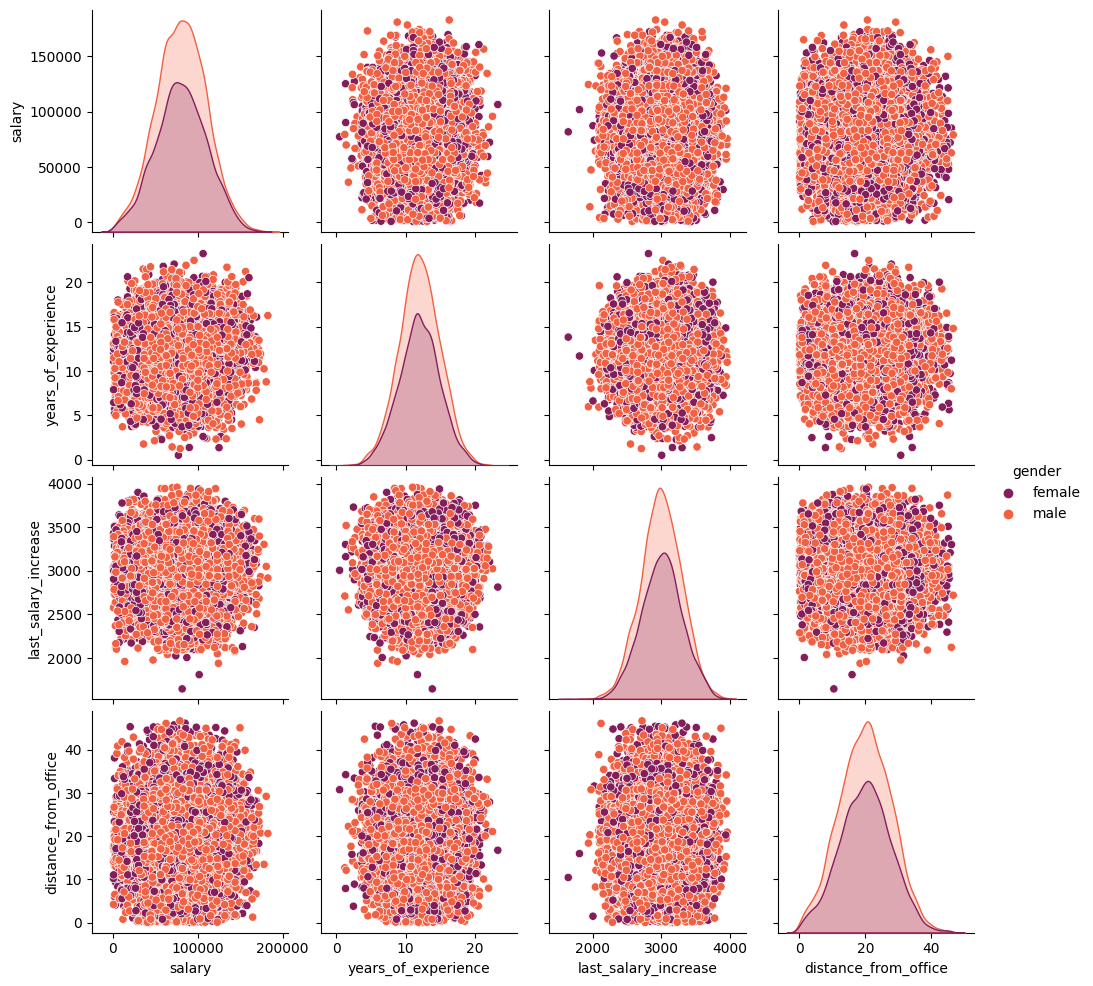

In [ ]:
sns.displot(original_data, x="salary", hue="gender", kind="kde", fill=True, palette="mako")
sns.displot(synthetic_data, x="salary", hue="gender", kind="kde", fill=True, palette="rocket")
sns.pairplot(original_data, hue="gender", palette="mako")
sns.pairplot(synthetic_data, hue="gender", palette="rocket")

## Statistics of Biggest Cohort in the Data
Find the biggest cohort in the data set identified by the department, gender, and city. Compare the statistics of the cohort in the original and synthetic data sets.


In [ ]:
original_data_groupby = original_data.groupby(['department', 'gender', \
                        'city'])['salary'].agg([np.size, np.mean, np.std, np.var, \
                                                np.median, np.min, np.max])

## find population cohort with most rows
original_data_groupby.sort_values(by=['size'], inplace=True, ascending=False)
print(original_data_groupby)

                                        size           mean           std  \
department        gender city                                               
Legal             male   Seattle        1395   78924.803769  29936.014758   
Finance           female Seattle         960   78477.744469  29562.900909   
HR                female Santa Cruz      920   80042.853077  31662.515249   
IT                male   Chicago         875   80083.484176  29767.330017   
Call Center       male   New York        770   80229.766585  29559.801645   
...                                      ...            ...           ...   
Engineering       female Santa Cruz        4   83174.887343  22354.802444   
HR                male   San Francisco     4   83958.865935  32351.300541   
Technicians       male   Ithaca            4  103229.528503  35981.264239   
HR                male   Miami             4   64723.786710  23051.342288   
Facility Services female Santa Cruz        4   77826.483757  31000.767098   

In [ ]:
od_group = original_data.loc[(original_data['department']=='Legal') & \
           (original_data['gender']=='male') & (original_data['city']=='Seattle')]
print('population cohort from original data')
od_group[['salary', 'years_of_experience', 'last_salary_increase', \
          'distance_from_office']].describe()

population cohort from original data


,salary,years_of_experience,last_salary_increase,distance_from_office
count,1395.000000,1395.000000,1395.000000,1395.000000
mean,78924.803769,11.951813,2998.044380,19.992557
std,29936.014758,2.973660,303.045440,7.851552
min,407.222975,2.113717,1937.279816,0.097469
25%,60140.585550,9.916064,2795.344806,14.759447
50%,79031.078570,11.938486,2990.526767,19.961917
75%,99402.243190,13.911907,3199.438477,25.281910
max,172835.514000,22.677674,4083.691124,51.511892


In [ ]:
sd_group = synthetic_data.loc[(synthetic_data['department']=='Legal') & \
           (synthetic_data['gender']=='male') & (synthetic_data['city']=='Seattle')]
print('population cohort from synthetic data')
sd_group[['salary', 'years_of_experience', 'last_salary_increase', \
          'distance_from_office']].describe()

population cohort from synthetic data


,salary,years_of_experience,last_salary_increase,distance_from_office
count,1395.000000,1395.000000,1395.000000,1395.000000
mean,79568.645676,11.935418,2988.324680,19.846698
std,30620.157983,3.016003,304.974832,7.829388
min,1695.798109,2.354867,1959.948518,0.242984
25%,59416.581599,9.918753,2783.386809,14.460209
50%,79838.770444,11.882484,2993.418019,19.995083
75%,100304.145741,13.873008,3175.441896,25.328192
max,171746.113102,21.471915,3958.522202,42.377013


## Original and Synthetic Data Comparison
The following cell combines the original and synthetic data sets and creates pairwise plots for the metrics. The charts suggest that there is no substantial differences between the two data sets.

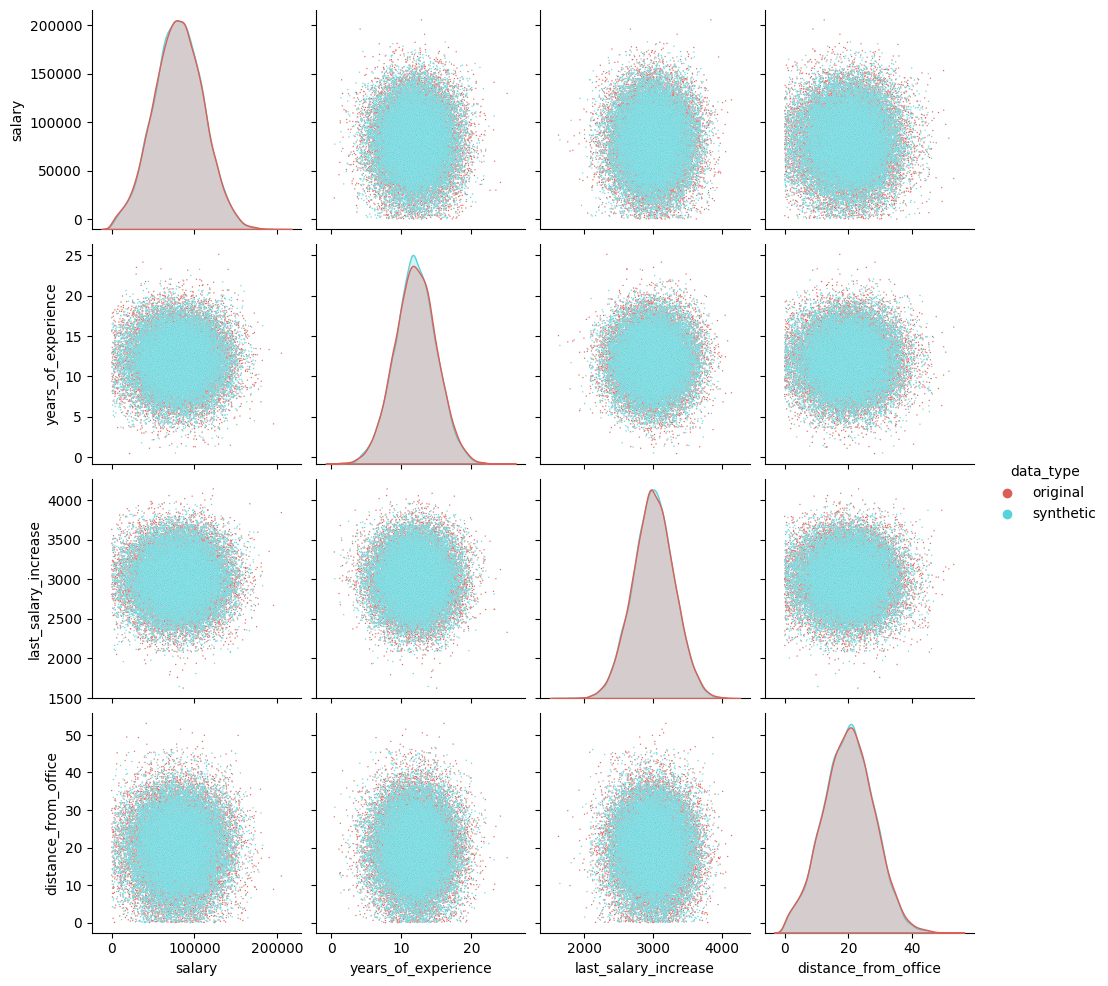

In [ ]:
odata_concat = original_data
odata_concat['data_type']='original'
sdata_concat = synthetic_data
sdata_concat['data_type']='synthetic'
concat_data = pd.concat([odata_concat, sdata_concat], ignore_index=True)

sns.pairplot(concat_data, hue='data_type', plot_kws={'s':1}, palette='hls')


## Locating Pay Inequality
After confirming that the original and synthetic data sets are similar, the synthetic data can be processed to locate the cohorts with unfair salaries.

The following cell loops through the synthetic data to calculate the salary difference between female and male, and calculate the statistical signifiance of the differences.
* For each department, city, store the female and male salaries in two separate arrays.
* Create an array that combines the female and male salaries.
* Calculate the average of the female, male, all salaries.
* Calculate t-test statistics and p-value of the female and male salaries.
* Divide the absolute difference of the female and male salaries by the overall salary average.
* Store all the statistics calculated in an array. Combines all the arrays into one output array.

In [ ]:
## for each department and city calculate how different the salaries for female and male employees
## and calculate how significant the differences are
comp_t_stat = pd.DataFrame(columns=['department', 'city', 'all_groups_avg', \
                                    'female_avg_comp', 'male_avg_comp', 't_stat', \
                                    'p_value', 'stat_sig_pct', 'diff_pct'])

cities = synthetic_data['city'].unique()
departments = synthetic_data['department'].unique()

for department in departments:
  for city in cities:
    group1 = synthetic_data[(synthetic_data['gender'] == 'female') & \
             (synthetic_data['department'] == department) & \
             (synthetic_data['city'] == city)]['salary']
    group2 = synthetic_data[(synthetic_data['gender'] == 'male') & \
             (synthetic_data['department'] == department) & \
             (synthetic_data['city'] == city)]['salary']

    all_groups = synthetic_data[(synthetic_data['department'] == department) & \
                 (synthetic_data['city'] == city)]['salary']

    group1_avg = group1.mean()
    group2_avg = group2.mean()
    t_statistic, p_value = ttest_ind(group1, group2)
    all_groups_avg = all_groups.mean()

    group1_avg = np.nan_to_num(group1_avg)
    group2_avg = np.nan_to_num(group2_avg)
    all_groups_avg = np.nan_to_num(all_groups_avg)
    t_statistic = np.nan_to_num(t_statistic)
    p_value = np.nan_to_num(p_value)

    stat_sig_pct = round(100 * (1-p_value))

    if all_groups_avg == 0:
      diff_pct = 0
    else:
      diff_pct = round(100 * abs(group1_avg - group2_avg) / all_groups_avg)

    insert_data = {'department' : [department], 'city' : [city], \
                   'all_groups_avg' : [all_groups_avg], 'female_avg_comp' : [group1_avg], \
                   'male_avg_comp' : [group2_avg], 't_stat' : [t_statistic], \
                   'p_value' : [p_value], 'stat_sig_pct' : [stat_sig_pct], \
                   'diff_pct' : [diff_pct]}
    insert_df = pd.DataFrame(insert_data)
    comp_t_stat= pd.concat([comp_t_stat, insert_df], ignore_index=True)

print(comp_t_stat)

               department           city  all_groups_avg  female_avg_comp  \
0              Accounting     Pittsburgh    80173.540113     76365.402485   
1              Accounting         Austin        0.000000         0.000000   
2              Accounting         Denver        0.000000         0.000000   
3              Accounting        Seattle        0.000000         0.000000   
4              Accounting        Chicago        0.000000         0.000000   
..                    ...            ...             ...              ...   
255  Warehouse Leadership          Miami        0.000000         0.000000   
256  Warehouse Leadership  San Francisco        0.000000         0.000000   
257  Warehouse Leadership     Santa Cruz        0.000000         0.000000   
258  Warehouse Leadership         Ithaca    76803.472907     70816.285647   
259  Warehouse Leadership      Palo Alto        0.000000         0.000000   

     male_avg_comp    t_stat   p_value stat_sig_pct diff_pct  
0     81066.

## Heatmap Chart
Heatmap chart can display the percentage difference and statistical significance in one chart.
* The numbers in the cell show the percentage differences between female and male salaries.
* The intensity of the color shows how statistically significant the differences are, the darker the cells the more likely that the differences are real.

<Axes: xlabel='city', ylabel='department'>

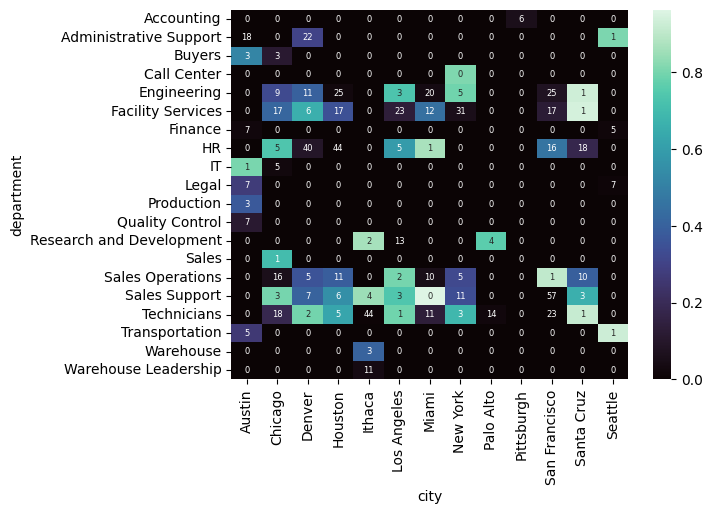

In [ ]:
## create heatmap chart to identify the department and city with
## biggest percentage difference between female and male salaries (the numbers in the cell)
## and how significant the difference is (the darker the more significant)
pivot = comp_t_stat.pivot_table(index='department', columns='city', values='p_value')

sns.heatmap(pivot, annot=comp_t_stat.pivot_table(index='department', columns='city', \
            values='diff_pct'), annot_kws={"fontsize":6}, fmt='.3g', cmap='mako')

The top three cells where the salary differences are statistically significant are Miami-Engineering, Houston-HR, and Ithaca-Technicians. The following table and chart show how different the salary distributions are for those three cohorts. For those three cohorts, the average female salary is `$69,257`, while the average male salary is `$88,120`.

The following cell combines the three cohorts and compares the distributions of the female and male salaries for the three cohorts.

                 department     city  all_groups_avg  female_avg_comp  \
14   Administrative Support   Austin    78509.483251     74422.111095   
60              Engineering    Miami    81671.995590     71397.092764   
97                       HR  Houston    77222.555226     58555.207038   
219             Technicians   Ithaca    92886.209399     84379.563344   
258    Warehouse Leadership   Ithaca    76803.472907     70816.285647   

     male_avg_comp    t_stat   p_value stat_sig_pct diff_pct  
14    88500.837412 -3.004209  0.003112          100       18  
60    87543.368634 -2.169852  0.034521           97       20  
97    92156.433777 -5.900845  0.000599          100       44  
219  124786.132106 -3.061066  0.007070           99       44  
258   79444.879052 -2.113987  0.035535           96       11  


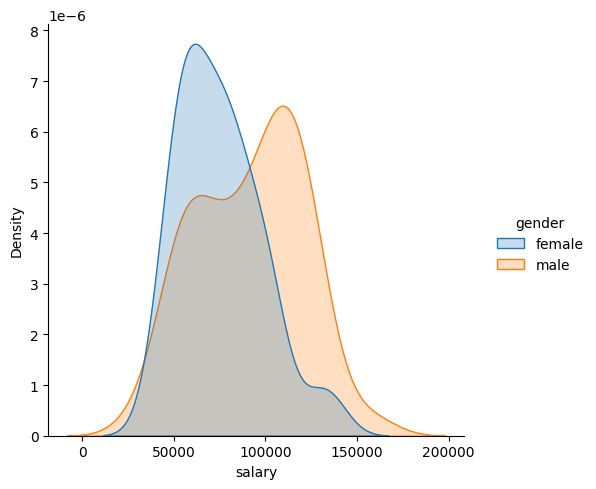

In [ ]:
## find cohorts with high p-value and high percentage difference
print(comp_t_stat.loc[(comp_t_stat['p_value']<=0.05) & (comp_t_stat['diff_pct']>=10) & \
     (comp_t_stat['male_avg_comp']>comp_t_stat['female_avg_comp'])])

cohort1 = synthetic_data[(synthetic_data['department']=='HR') & \
          (synthetic_data['city']=='Houston')]
cohort2 = synthetic_data[(synthetic_data['department']=='Engineering') & \
          (synthetic_data['city']=='Miami')]
cohort3 = synthetic_data[(synthetic_data['department']=='Technicians') & \
          (synthetic_data['city']=='Ithaca')]

unfair_cohort = pd.concat([cohort1, cohort2, cohort3], ignore_index=True)
sns.displot(unfair_cohort, x="salary", hue="gender", fill=True, kind="kde")

The following cell prints the female statistics of the unfair cohorts.

In [ ]:
unfair_cohort.loc[unfair_cohort['gender']=='female'][['salary', 'years_of_experience', \
                  'last_salary_increase', 'distance_from_office']].describe()


,salary,years_of_experience,last_salary_increase,distance_from_office
count,24.000000,24.000000,24.000000,24.000000
mean,69256.778476,11.475000,2838.957106,18.798444
std,18352.763622,2.243606,216.632328,7.055888
min,43471.539458,7.116787,2374.907629,5.670347
25%,52527.779421,10.203216,2708.411269,12.847370
50%,67327.100841,10.596733,2808.493599,19.356106
75%,82877.453310,13.377287,2973.412228,22.305742
max,100118.996483,15.797783,3308.027003,32.828361


The following cell calculates the male statistics of the unfair cohorts.

In [ ]:
unfair_cohort.loc[unfair_cohort['gender']=='male'][['salary', 'years_of_experience', \
                  'last_salary_increase', 'distance_from_office']].describe()


,salary,years_of_experience,last_salary_increase,distance_from_office
count,40.000000,40.000000,40.000000,40.000000
mean,88120.001777,11.852253,3038.694670,19.835597
std,28079.874958,2.645983,227.739091,5.639141
min,32323.578153,6.750513,2564.503126,10.209317
25%,61940.957793,10.083530,2920.616923,15.018304
50%,91706.335745,11.614330,3023.328266,18.707029
75%,107838.219634,12.997809,3183.527800,24.632992
max,157476.862277,16.932317,3378.954654,29.436654


The following cell prints the original and synthetic data into text files.

In [ ]:
original_data.to_csv('workplace_fairness_original_data.csv')
synthetic_data.to_csv('workplace_fairness_synthetic_data.csv')